In [1]:
# prompt: mount drive, and Chdir to MRSA Dataset

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MRSA datasets
# !ls

import numpy as np
!pip install biopython
!pip install fcgr-0.1-py3-none-any.whl
from fcgr import chaos_game_representation_key,return_kmer_index , \
read_fasta, return_kmer_at_index
from google.colab import drive
import os
import pandas as pd
from Bio import SeqIO
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/13LGqe__ULhjG0hZmpgxz8WqE0fNXsVNQ/MRSA datasets
Processing ./fcgr-0.1-py3-none-any.whl
fcgr is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
import torch

state_dict=torch.load("/content/drive/MyDrive/MRSA datasets/Models/Cross Validation/Salmonella_batch32_epoch19_2/Salmonella_batch32_epoch19_2_MixUp0.1_ResNet_42.pth",  map_location=torch.device('cpu'), weights_only=False)['model']

In [3]:


def return_kmer_count(sequence:str, kmer_length:int):

    """
    Calculate the count of all k-mers of a specified length in a given DNA sequence.

    Parameters:
        - sequence (str): The input DNA sequence.
        - kmer_length (int): The length of k-mers to calculate the count for.

    Returns:
        - kmer_counts (dict): A dictionary containing all k-mers of the specified length
                              as keys and their counts in the DNA sequence as values.
    """

    from collections import defaultdict
    kmer_counts = defaultdict(int)
    kmer_positions = defaultdict(list)
    bin_floor = lambda x, bin_size: (x // bin_size) * bin_size


    for i in range(len(sequence) - kmer_length + 1):
        kmer = sequence[i:i + kmer_length]
        kmer_counts[kmer] += 1
        kmer_positions[kmer].append( i )

    return dict(kmer_counts), dict(kmer_positions)


def replace_non_atgc(sequence):

    """
    Replace non-ATGC characters in a DNA sequence with 'N'.

    Parameters:
        - sequence (str): The input DNA sequence.

    Returns:
        - result (str): The DNA sequence with non-ATGC characters replaced with 'N'.
    """
    result = ''.join(char if char in ['A', 'T', 'G', 'C', 'N'] else 'N' for char in sequence)

    return result


def chaos_frequency_matrix(fasta_string: str, kmer_length: int, chaos_game_kmer_array: np.array=None,  pseudo_count = True):




    """
    Generates the chaos frequency matrix for the given DNA sequence.

    This function calculates the Chaos Frequency Matrix (CFM) for a given DNA sequence and k-mer length,
    using the Chaos Game Representation (CGR) key matrix.

    Parameters:
        fasta_string (str): The DNA sequence in FASTA format.
        kmer_length (int): The length of the k-mers to consider.
        chaos_game_kmer_array (np.array, optional): The Chaos Game Representation (CGR) key matrix. Defaults to None.
        pseudo_count (bool, optional): Whether to apply pseudo-counts to the matrix. Defaults to True.

    Returns:
        tuple: A tuple containing:
            - np.array: The chaos frequency matrix representing k-mer frequencies.
            - np.array: The Chaos Game Representation (CGR) key matrix used.
    """

    import numpy as np
    import sys
    import pandas as pd

    if isinstance(kmer_length, int)==False:
        sys.exit("The k-mer length is not valid. Please provide a integer k-mer value.")

    if kmer_length<1:
        sys.exit("The k-mer length cannot be less than 1.")
    if isinstance(fasta_string, str)==False:
        sys.exit("The fasta string contain non string value. It should contain only string.")

    fasta_string = fasta_string.upper()
    fasta_string = replace_non_atgc(fasta_string)

    if chaos_game_kmer_array is None:
        chaos_game_kmer_array = chaos_game_representation_key(kmer_length)

    rows = np.power(2, kmer_length)
    fcgr_sequence, positions = return_kmer_count(fasta_string, kmer_length=kmer_length)
    fcgr_sequence_lookup = {k.upper(): v for k, v in fcgr_sequence.items()}
    matrix2 = np.zeros((rows, rows))

    for (i, j), value in np.ndenumerate(chaos_game_kmer_array):
        upper_value = value.upper()
        if upper_value in fcgr_sequence_lookup:
            matrix2[i, j] = fcgr_sequence_lookup[upper_value]

    if pseudo_count==True:
        matrix2 = (matrix2 + np.ones((matrix2.shape[0],matrix2.shape[1])))

    return matrix2, positions, chaos_game_kmer_array


In [4]:
import torchvision.models as models
from torch import nn
def create_resnet(NUM_CLASSES, in_channels=1, pretrained=False):
    model = models.resnet18(weights=None)

    orig = model.conv1
    model.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=orig.out_channels,
        kernel_size=orig.kernel_size,
        stride=orig.stride,
        padding=orig.padding,
        bias=orig.bias is not None
    )

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    return model


In [5]:
'''
Normalization Functions
'''
default_kmer_length=8
def normalize_log(fcgr_freq_matrix):
  log_scaled = np.log1p(fcgr_freq_matrix)
  fcgr_freq_matrix_normalized= (log_scaled - np.min(log_scaled)) / (np.max(log_scaled) - np.min(log_scaled))
  return fcgr_freq_matrix_normalized


def normalize_min_max(x):
  return (x - np.min(x)) / (np.max(x) - np.min(x))

def normalize_standard(x):
  return (x - np.mean(x)) / np.std(x)

def normalize_none(x):
  return x


def get_normalizations():
  return { "log":normalize_log,
           "min_max":normalize_min_max,
           "standard":normalize_standard,
  }

def preprocessor_chaos_encoding(input_data, kmer_length=default_kmer_length,
                                normalization="min_max"):

  fcgr_freq_matrix, positions ,fcgr_key_array =chaos_frequency_matrix(fasta_string= input_data,
                                                                 kmer_length=kmer_length, chaos_game_kmer_array=None,
                                                                 pseudo_count = False)


  fcgr_freq_matrix=get_normalizations()[normalization](fcgr_freq_matrix)

  return fcgr_freq_matrix, positions



In [6]:
model=create_resnet(NUM_CLASSES=7)

In [7]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
model.eval()


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
import numpy as np
mat=np.load('/content/drive/MyDrive/MRSA datasets/Datasets_fcgr/Salmonella enterica/PRJNA292666 & PRJNA292661/SRR1177339.fna.npy')

In [10]:
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms

class MinMaxNormalize:
    def __init__(self, new_min=0.0, new_max=1.0):
        self.new_min = new_min
        self.new_max = new_max

    def __call__(self, tensor):
        min_val = tensor.min()
        max_val = tensor.max()
        if max_val - min_val == 0:
            return tensor
        return (tensor - min_val) / (max_val - min_val) * (self.new_max - self.new_min) + self.new_min


transform = transforms.Compose( [

    transforms.Lambda(lambda x: x.astype(np.float32)),
    ToTensor(),
    #transforms.RandomApply([ AddRandomIntegerNoise(low=0, high=10) ], p=0.1), # Low probability of adding noise
    #transforms.Lambda(lambda x: torch.log10(x + 1e-6)), # log normalization
    MinMaxNormalize(),

  ]
)


In [11]:
x=transform(mat)
x.unsqueeze_(0)
x.shape

torch.Size([1, 1, 256, 256])

In [12]:
with torch.no_grad():
  out=model(x)
out
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
1-torch.sigmoid(out).squeeze()

tensor([0.4924, 0.0179, 0.0178, 0.0242, 0.0084, 0.0035, 0.0094])

In [14]:
import pandas as pd
def load_all_sequences(filepath):
    """
    Load and concatenate all sequences from a .fasta or .fna file.
    """
    records = SeqIO.parse(filepath, "fasta")
    full_sequence = "".join(str(record.seq).upper() for record in records)
    return full_sequence

get_sequence = lambda df, x: load_all_sequences(dataset_path + '/' + df['Species'][x] + '/' + df['Dataset'][x] + '/' + df['File Name'][x])
dataset_path = 'Datasets'
Master_Table = pd.read_csv('Master_Table.csv')

test_sequence=load_all_sequences('/content/drive/MyDrive/MRSA datasets/Datasets/Salmonella enterica/PRJNA292666 & PRJNA292661/SRR1177339.fna')
test_sequence_array = np.fromiter(test_sequence, dtype='U1')


/tmp/ipython-input-619080171.py:12: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,22,23,24,25,27,28,30,31,33,34,35,36,37,40,41,42,43,46,47,48,49,50,51,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  Master_Table = pd.read_csv('Master_Table.csv')


In [15]:
# Load the dataframe
df = pd.read_csv("/content/Salmonella enterica_Model_Table_clusters(1).csv")

# Assuming 'Ceftiofur' is a column name in your dataframe
# Filter for rows where 'Ceftiofur' is 'R'
ceftiofur_resistant_df = df[df['Ceftiofur'] == 'R'].copy()

# Display the first few rows of the filtered dataframe
display(ceftiofur_resistant_df.head())

# Display the shape of the filtered dataframe
print(f"Shape of the filtered dataframe (Ceftiofur is R): {ceftiofur_resistant_df.shape}")

,Species,Dataset,File Name,Tetracycline,Ampicillin,Amoxicillin-Clavulanic acid,Cefoxitin,Ceftiofur,Gentamicin,Ceftriaxone,clusters
45,Salmonella enterica,PRJNA292666 & PRJNA292661,SRR1195631.fna,R,R,R,I,R,S,S,5
62,Salmonella enterica,PRJNA292666 & PRJNA292661,SRR1198890.fna,R,R,R,I,R,S,S,0
68,Salmonella enterica,PRJNA292666 & PRJNA292661,SRR1198931.fna,S,R,R,I,R,S,I,25
73,Salmonella enterica,PRJNA292666 & PRJNA292661,SRR1198962.fna,R,R,R,I,R,R,S,5
74,Salmonella enterica,PRJNA292666 & PRJNA292661,SRR1198972.fna,S,R,R,I,R,S,S,0


Shape of the filtered dataframe (Ceftiofur is R): (719, 11)


In [16]:
# Define the drug columns to check for minimal resistance
drug_columns = ['Tetracycline', 'Ampicillin', 'Amoxicillin-Clavulanic acid', 'Cefoxitin', 'Gentamicin', 'Ceftriaxone']

# Filter the ceftiofur_resistant_df
minimal_other_resistance_df = ceftiofur_resistant_df[
    ceftiofur_resistant_df[drug_columns].apply(
        lambda row: row.isin(['R', 'I']).sum(), axis=1
    ) <= 3
].copy()

# Display the first few rows of the new filtered dataframe
display(minimal_other_resistance_df.head())

# Display the shape of the new filtered dataframe
print(f"Shape of the new filtered dataframe (Ceftiofur is R and minimal other resistance): {minimal_other_resistance_df.shape}")

,Species,Dataset,File Name,Tetracycline,Ampicillin,Amoxicillin-Clavulanic acid,Cefoxitin,Ceftiofur,Gentamicin,Ceftriaxone,clusters
74,Salmonella enterica,PRJNA292666 & PRJNA292661,SRR1198972.fna,S,R,R,I,R,S,S,0
93,Salmonella enterica,PRJNA292666 & PRJNA292661,SRR1202988.fna,S,R,R,I,R,S,S,25
123,Salmonella enterica,PRJNA292666 & PRJNA292661,SRR1257274.fna,S,R,R,I,R,S,S,4
1147,Salmonella enterica,PRJNA292666 & PRJNA292661,SRR1973886.fna,S,R,R,R,R,S,S,82
1557,Salmonella enterica,PRJNA292666 & PRJNA292661,SRR2407662.fna,S,R,R,I,R,S,S,0


Shape of the new filtered dataframe (Ceftiofur is R and minimal other resistance): (16, 11)


In [17]:
# Select the first row from the filtered dataframe

dataset_path = '/content/drive/MyDrive/MRSA datasets/Datasets'
first_row = minimal_other_resistance_df.iloc[0]

# Construct the file path using the first three columns
file_path = os.path.join(dataset_path, first_row['Species'], first_row['Dataset'], first_row['File Name'])

print(f"File path for the first sequence: {file_path}")

File path for the first sequence: /content/drive/MyDrive/MRSA datasets/Datasets/Salmonella enterica/PRJNA292666 & PRJNA292661/SRR1198972.fna


In [18]:
# Load the sequence data from the file path
sequence_data = load_all_sequences(file_path)

# Preprocess the sequence data to get the FCGR matrix
# Using kmer_length=8 and normalization="min_max" as in previous cells
fcgr_matrix, positions = preprocessor_chaos_encoding(sequence_data, kmer_length=8, normalization="min_max")

# Apply the transformation (ToTensor, MinMaxNormalize) to the FCGR matrix
# Assuming the transform defined in cell aF_JGKVHQgFY is suitable
x = transform(fcgr_matrix)

# Add a batch dimension as the model expects input in the shape [Batch_size, Channels, Height, Width]
x.unsqueeze_(0)

print(f"Shape of the preprocessed input tensor x: {x.shape}")

Shape of the preprocessed input tensor x: torch.Size([1, 1, 256, 256])


In [19]:
chaos_mat, positions, keys=chaos_frequency_matrix(test_sequence, 8)

In [20]:
import torch
import torch.nn.functional as F

def compute_saliency(model, img_tensor, target_class):
    # img_tensor: 1×C×H×W, requires_grad=True
    img_tensor.requires_grad_()
    model.zero_grad()

    out = model(img_tensor)                     # forward
    score = out[0, target_class]                # pick the logit for the target class
    score.backward()                            # compute gradients

    saliency = img_tensor.grad.abs().squeeze()  # C×H×W
    # If you want a single-channel map, you can max over colors:
         # H×W
    return saliency.detach().cpu()


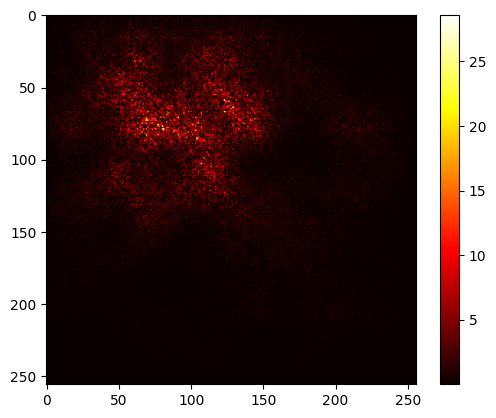

In [21]:
import matplotlib.pyplot as plt

saliency_map=compute_saliency(model, x, 4)
saliency_map

plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.show()


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive

def generate_relevancy_regions(saliency_map, keys, sequence_data, bin_size=10000, window_size=500):
    flat_keys = [str(key) for key in keys.flatten()]
    flat_values = saliency_map.flatten().cpu().numpy().tolist()
    value_map = dict(zip(flat_keys, flat_values))

    length_sequence = len(sequence_data)
    length_kmer = 8
    # Ensure we only look up k-mers that are present in the value_map (generated from keys)
    # This also implicitly handles sequence length vs. matrix size
    relevancy_map = []
    for kmer_start in range(length_sequence - length_kmer + 1):
        kmer = sequence_data[kmer_start:kmer_start + length_kmer].upper() # Ensure kmer is uppercase
        if kmer in value_map:
             relevancy_map.append(value_map[kmer])
        else:
             # Handle cases where a k-mer from the sequence is not in the keys (shouldn't happen with chaos_frequency_matrix keys)
             # Or if there are 'N's or other non-ATGC characters. Let's assign a default value (e.g., 0) or skip
             relevancy_map.append(0) # Assign 0 relevancy for missing k-mers

    relevancy_map = np.array(relevancy_map)

    # Binning the relevancy map
    # Adjust the range for add.reduceat to handle potential length differences after filtering missing kmers
    # This might need a more robust approach if many kmers are missing. Assuming minimal missing for now.
    binned_relevancy_map = np.add.reduceat(relevancy_map, np.arange(0, len(relevancy_map), bin_size))

    # Apply the low-pass filter
    # Ensure window_size is not larger than the binned map length
    if window_size > len(binned_relevancy_map):
        print(f"Warning: window_size ({window_size}) is larger than the binned map length ({len(binned_relevancy_map)}). Adjusting window_size.")
        window_size = len(binned_relevancy_map) # Or handle differently, e.g., return empty/error
        if window_size == 0:
             print("Binned map is empty. Cannot apply window.")
             return np.array([]) # Return empty array or handle error

    filtered_binned_map = np.convolve(binned_relevancy_map, np.ones(window_size) / window_size, mode='valid')

    # Calculate the x-axis for the binned and filtered data (true sequence indices)
    # The valid mode convolution reduces the length of the output. The x-indices should correspond
    # to the start of the window in the original binned map.
    # The length of filtered_binned_map is len(binned_relevancy_map) - window_size + 1
    # The corresponding indices in the original sequence would start from 0, bin_size, 2*bin_size...
    # For a window of size W, the first valid output corresponds to the window starting at index 0 of the binned map.
    # The indices in the original sequence for the start of these windows would be:
    # 0 * bin_size, 1 * bin_size, 2 * bin_size, ..., (len(filtered_binned_map)-1) * bin_size
    x_indices = np.arange(0, len(filtered_binned_map)) * bin_size


    # Plotting
    plt.figure(figsize=(12, 6)) # Increase figure size for better visualization
    plt.plot(x_indices, filtered_binned_map, label='Filtered Binned Map')
    plt.legend()
    plt.title('Low Pass Filtered Binned Relevancy Map')
    plt.xlabel('Sequence Index')
    plt.ylabel('Mean Relevancy')
    plt.grid(True)
    plt.show()

    return filtered_binned_map

def interactive_plot(saliency_map, keys, sequence_data):
    bin_size_slider = widgets.IntSlider(value=500, min=100, max=len(sequence_data)//2, step=100, description='Bin Size:')
    window_size_slider = widgets.IntSlider(value=500, min=1, max=min(20000, len(sequence_data)//10), step=50, description='Window Size:') # Adjust max based on sequence length

    # Ensure bin_size and window_size limits are reasonable based on sequence length
    max_bin_size = len(sequence_data) // 2 if len(sequence_data) > 1 else 1
    max_window_size = len(sequence_data) // 10 if len(sequence_data) > 10 else 1
    bin_size_slider.max = max_bin_size
    window_size_slider.max = max_window_size
    if bin_size_slider.value > max_bin_size: bin_size_slider.value = max_bin_size
    if window_size_slider.value > max_window_size: window_size_slider.value = max_window_size
    if window_size_slider.value < window_size_slider.min: window_size_slider.value = window_size_slider.min


    interactive_plot = interactive(generate_relevancy_regions,
                                   saliency_map=widgets.fixed(saliency_map),
                                   keys=widgets.fixed(keys),
                                   sequence_data=widgets.fixed(sequence_data), # Pass the correct sequence data
                                   bin_size=bin_size_slider,
                                   window_size=window_size_slider)

    display(interactive_plot)

# Ensure saliency_map and keys are available from previous steps
# You also need the sequence_data that was used to generate the saliency_map
# Assuming sequence_data is the variable holding the sequence string from the file_path

# Use the saliency_map generated in cell -cSMuxl22dZE
# Use the keys generated in cell cN6J9NyS5-UI (from the original test_sequence) - ISSUE HERE: keys must match the sequence used for saliency
# Let's regenerate keys using the sequence_data

# Regenerate keys for the sequence_data
# Need to run chaos_frequency_matrix on sequence_data to get matching keys
# fcgr_matrix, positions, keys_for_saliency_sequence = chaos_frequency_matrix(fasta_string=sequence_data, kmer_length=8, pseudo_count = False)
# Note: fcgr_matrix and positions are already calculated in cell c415247a. We just need the keys from that calculation.
# However, chaos_frequency_matrix in cell jO8N6KKW49MD returns the keys as the 3rd element.
# Let's update cell c415247a to also return keys.

# For now, assuming keys generated in cell cN6J9NyS5-UI are sufficient if using test_sequence for plot.
# BUT the goal is to use the sequence from minimal_other_resistance_df.
# So we need keys from sequence_data.

# Let's run chaos_frequency_matrix on sequence_data here to get the correct keys
# This might be redundant with cell c415247a, but ensures correct keys are used for the plot.
# fcgr_matrix_plot, positions_plot, keys_plot = chaos_frequency_matrix(fasta_string=sequence_data, kmer_length=8, pseudo_count = False)
# Use keys_plot for the interactive plot.

# Assuming the saliency_map is from cell -cSMuxl22dZE
# Assuming sequence_data is from cell c415247a
# We need the keys that were used to generate the FCGR matrix for the sequence_data in cell c415247a.
# The preprocessor_chaos_encoding function in cell EthXWx-P5kLZ *does* return the keys as the 3rd output, but it's not captured in cell c415247a.

# Let's modify cell c415247a to capture the keys.
# For now, let's recalculate keys here for demonstration, but modifying c415247a is cleaner.
# fcgr_matrix_temp, positions_temp, keys_for_plot = chaos_frequency_matrix(fasta_string=sequence_data, kmer_length=8, pseudo_count = False)


# TEMPORARY FIX: Recalculate keys for sequence_data here for the plot
# This should ideally be done once when sequence_data is processed.
fcgr_matrix_for_plot, positions_for_plot, keys_for_plot = chaos_frequency_matrix(fasta_string=sequence_data, kmer_length=8, pseudo_count = False)


interactive_plot(saliency_map, keys_for_plot, sequence_data) # Pass the correct keys and sequence_data

interactive(children=(IntSlider(value=500, description='Bin Size:', max=2489574, min=100, step=100), IntSlider…

Top 200 Most Affecting K-mers and their Saliency Values:


,0
CTTTTTGC,28.619881
GTGGCTAT,26.569344
AGGGCTAT,26.482613
TGGCGCAT,23.041550
AATAAACT,22.316807
...,...
AAAACATT,10.360575
GTAAAACT,10.353483
AAGTAACT,10.317363
CCTATTAT,10.314800


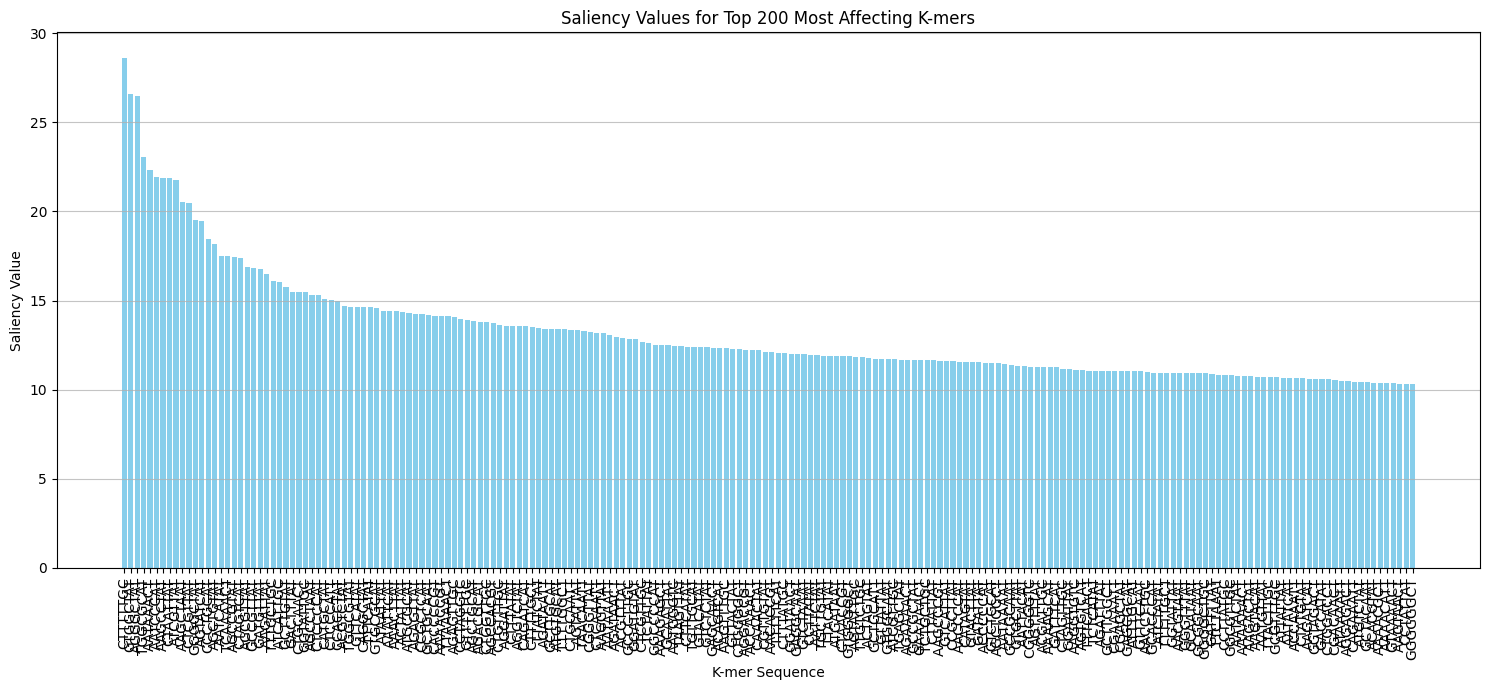

In [23]:
# Ensure saliency_map and keys_for_plot are available from previous steps
# Assuming saliency_map is from cell -cSMuxl22dZE
# Assuming keys_for_plot is from cell Lz7Vwz_8Relq

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for easier sorting and display

# 1. Map saliency values back to k-mers
# Flatten the keys and saliency map
flat_keys = [str(key) for key in keys_for_plot.flatten()]
flat_values = saliency_map.flatten().cpu().numpy().tolist()

# Create a dictionary mapping k-mers to their saliency values
kmer_saliency_map = dict(zip(flat_keys, flat_values))

# Convert to a pandas Series for easier sorting
kmer_saliency_series = pd.Series(kmer_saliency_map)

# 2. Identify the top 200 k-mers based on saliency
# Sort the k-mers by saliency value in descending order
sorted_kmer_saliency = kmer_saliency_series.sort_values(ascending=False)

# Define the number of top k-mers to display
top_n = 200

# Get the top N most affecting k-mers
top_kmers = sorted_kmer_saliency.head(top_n)

# 3. Display the list of top k-mers and their saliency values
print(f"Top {top_n} Most Affecting K-mers and their Saliency Values:")
display(top_kmers)

# 4. Generate a bar plot of the saliency values for these top k-mers
plt.figure(figsize=(15, 7)) # Increase figure size for better readability
plt.bar(top_kmers.index, top_kmers.values, color='skyblue')
plt.title(f'Saliency Values for Top {top_n} Most Affecting K-mers')
plt.xlabel('K-mer Sequence')
plt.ylabel('Saliency Value')
plt.xticks(rotation=90) # Rotate k-mer labels for better readability
plt.grid(axis='y', alpha=0.75)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

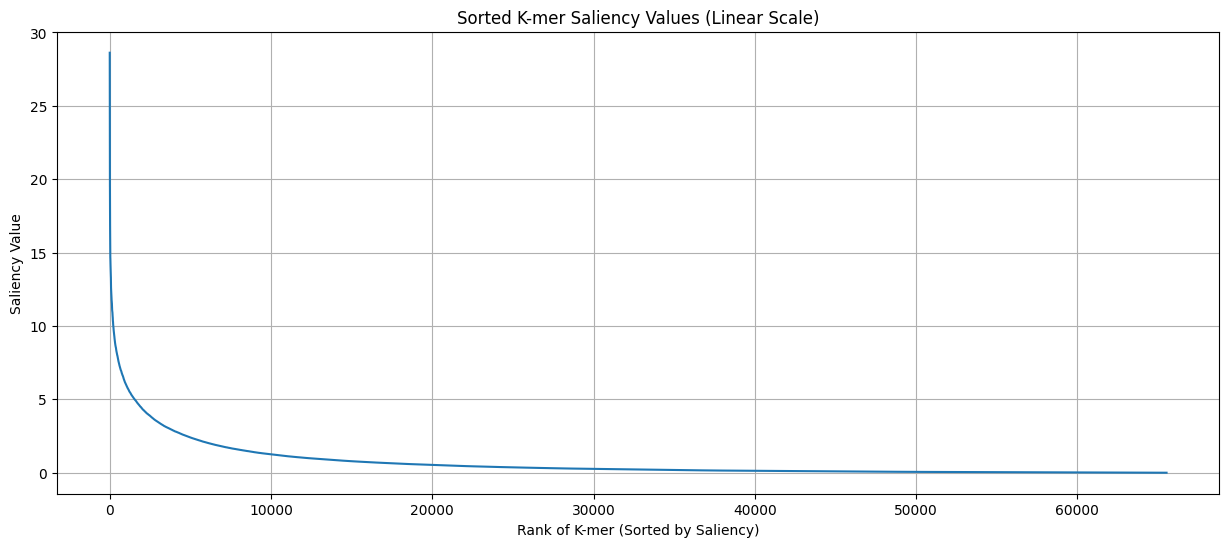

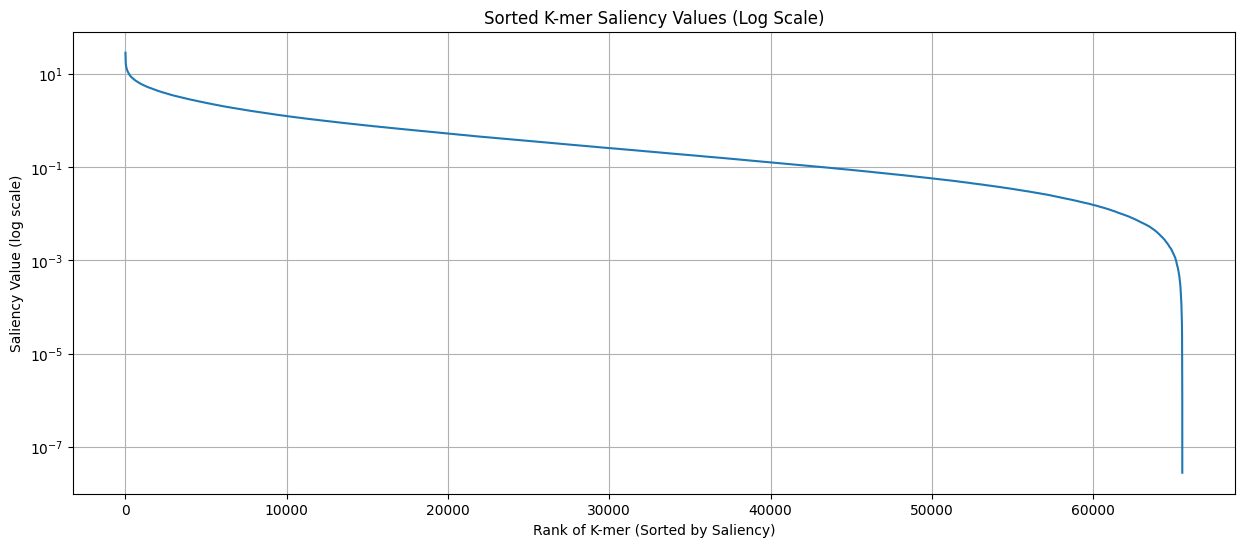

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming sorted_kmer_saliency is available from cell d8c0f6bf

# Plot sorted saliency values (linear scale)
plt.figure(figsize=(15, 6))
plt.plot(sorted_kmer_saliency.values)
plt.title('Sorted K-mer Saliency Values (Linear Scale)')
plt.xlabel('Rank of K-mer (Sorted by Saliency)')
plt.ylabel('Saliency Value')
plt.grid(True)
plt.show()

# Plot sorted saliency values (log scale for y-axis)
plt.figure(figsize=(15, 6))
plt.plot(sorted_kmer_saliency.values)
plt.yscale('log') # Set y-axis to log scale
plt.title('Sorted K-mer Saliency Values (Log Scale)')
plt.xlabel('Rank of K-mer (Sorted by Saliency)')
plt.ylabel('Saliency Value (log scale)')
plt.grid(True)
plt.show()

# Task
Generate a plot showing the sorted k-mer saliency values for 20-30 sequences from the `minimal_other_resistance_df` dataframe, with each sequence's curve plotted on the same graph to identify a general elbow point or trend for determining a meaningful cutoff for k-mer importance.

## Select sequences

### Subtask:
Choose a subset of 20-30 sequences from the `minimal_other_resistance_df` dataframe.


**Reasoning**:
Check the number of rows in `minimal_other_resistance_df` and select a subset of 20-30 sequences based on the number of available rows.



In [25]:
num_rows = minimal_other_resistance_df.shape[0]

if num_rows > 30:
    selected_sequences_df = minimal_other_resistance_df.sample(n=np.random.randint(20, 31), random_state=42)
elif 20 <= num_rows <= 30:
    selected_sequences_df = minimal_other_resistance_df.copy()
else:
    selected_sequences_df = minimal_other_resistance_df.copy()
    print(f"Warning: Less than 20 sequences available. Using all {num_rows} sequences.")

print(f"Selected {selected_sequences_df.shape[0]} sequences for analysis.")

Selected 16 sequences for analysis.


# Task
Generate a plot showing the sorted k-mer saliency values for 20-30 sequences from the "minimal_other_resistance_df" dataframe, with each sequence's curve plotted on the same graph to identify a general elbow point or trend for determining a meaningful cutoff for k-mer importance. If there are fewer than 20 entries, use all available. Then, combine the k-mer saliency values across all selected sequences and analyze the overall distribution.

## Process selected sequences

### Subtask:
Iterate through the `selected_sequences_df` dataframe. For each sequence, load the data, preprocess it to get the FCGR matrix, apply the necessary transformations, calculate the saliency map for the target class, and then extract and store the k-mer saliency values.


**Reasoning**:
Iterate through the selected sequences, process each sequence to get k-mer saliency values, and store them in a list.



In [26]:
all_kmer_saliency_values = []

for index, row in selected_sequences_df.iterrows():
    # Construct the file path
    file_path = os.path.join(dataset_path, row['Species'], row['Dataset'], row['File Name'])

    try:
        # Load the sequence data
        sequence_data = load_all_sequences(file_path)

        # Preprocess the sequence data to get the FCGR matrix and keys
        # Need to capture keys here for mapping saliency back to kmers
        fcgr_matrix, positions, keys = chaos_frequency_matrix(fasta_string=sequence_data, kmer_length=8, pseudo_count=False)

        # Apply the transformation (ToTensor, MinMaxNormalize) to the FCGR matrix
        x = transform(fcgr_matrix)

        # Add a batch dimension
        x.unsqueeze_(0)

        # Calculate the saliency map for the target class (assuming target_class is 4 as before)
        # Ensure x requires gradients for saliency calculation
        x.requires_grad_(True)
        saliency_map = compute_saliency(model, x, 4) # Assuming target_class 4 is relevant

        # Flatten the keys and saliency map
        flat_keys = [str(key) for key in keys.flatten()]
        flat_values = saliency_map.flatten().cpu().numpy().tolist()

        # Create a dictionary mapping k-mers to their saliency values for this sequence
        kmer_saliency_map = dict(zip(flat_keys, flat_values))

        # Store the k-mer saliency map for this sequence
        all_kmer_saliency_values.append(kmer_saliency_map)

        print(f"Processed sequence: {row['File Name']}")

    except Exception as e:
        print(f"Error processing sequence {row['File Name']}: {e}")
        continue # Continue with the next sequence if an error occurs

print("Finished processing all selected sequences.")

Processed sequence: SRR1198972.fna
Processed sequence: SRR1202988.fna
Processed sequence: SRR1257274.fna
Processed sequence: SRR1973886.fna
Processed sequence: SRR2407662.fna
Processed sequence: SRR2566912.fna
Processed sequence: SRR2567008.fna
Processed sequence: SRR2981108.fna
Processed sequence: SRR3131144.fna
Processed sequence: SRR3295776.fna
Processed sequence: SRR3664783.fna
Processed sequence: SRR3664929.fna
Processed sequence: SRR3664931.fna
Processed sequence: SRR3933003.fna
Processed sequence: SRR3933073.fna
Processed sequence: SRR4280594.fna
Finished processing all selected sequences.


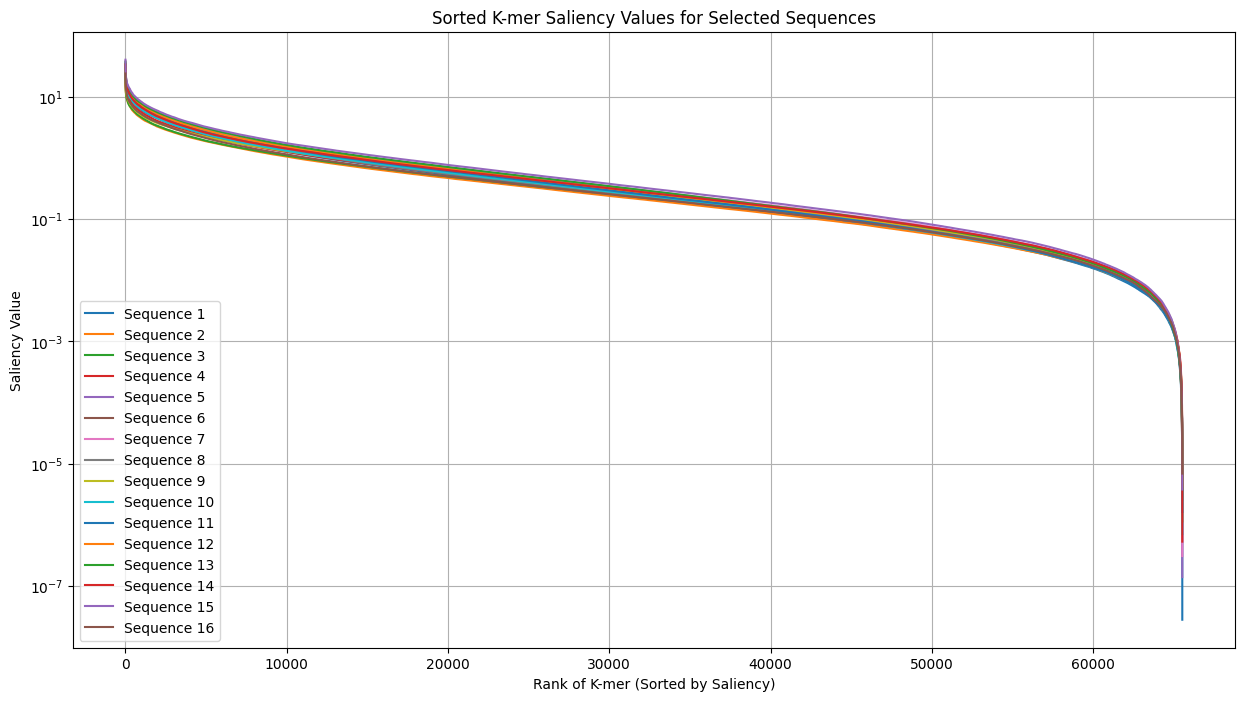

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(15, 8))

for i, kmer_saliency_map in enumerate(all_kmer_saliency_values):
    # Convert to a pandas Series for easier sorting
    kmer_saliency_series = pd.Series(kmer_saliency_map)

    # Sort the k-mers by saliency value in descending order
    sorted_kmer_saliency = kmer_saliency_series.sort_values(ascending=False)

    # Plot sorted saliency values
    plt.plot(sorted_kmer_saliency.values, label=f'Sequence {i+1}')

plt.title('Sorted K-mer Saliency Values for Selected Sequences')
plt.xlabel('Rank of K-mer (Sorted by Saliency)')
plt.ylabel('Saliency Value')
plt.yscale('log') # Use log scale for better visualization of the distribution
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from collections import defaultdict

# Combine saliency values across all sequences
combined_kmer_saliency = defaultdict(list)

for kmer_saliency_map in all_kmer_saliency_values:
    for kmer, saliency in kmer_saliency_map.items():
        combined_kmer_saliency[kmer].append(saliency)

# Calculate the mean saliency value for each k-mer
mean_kmer_saliency = {kmer: np.mean(saliencies) for kmer, saliencies in combined_kmer_saliency.items()}

# Convert to a pandas Series for easier analysis and sorting
mean_kmer_saliency_series = pd.Series(mean_kmer_saliency)

# Sort the k-mers by their mean saliency value
sorted_mean_kmer_saliency = mean_kmer_saliency_series.sort_values(ascending=False)

print("Combined and sorted mean k-mer saliency values:")
display(sorted_mean_kmer_saliency.head())

Combined and sorted mean k-mer saliency values:


,0
CTTTTTGC,28.710331
AGGGCTAT,27.590534
AATAAACT,27.103166
AAGCCTAT,26.824991
TGGCGCAT,26.261403


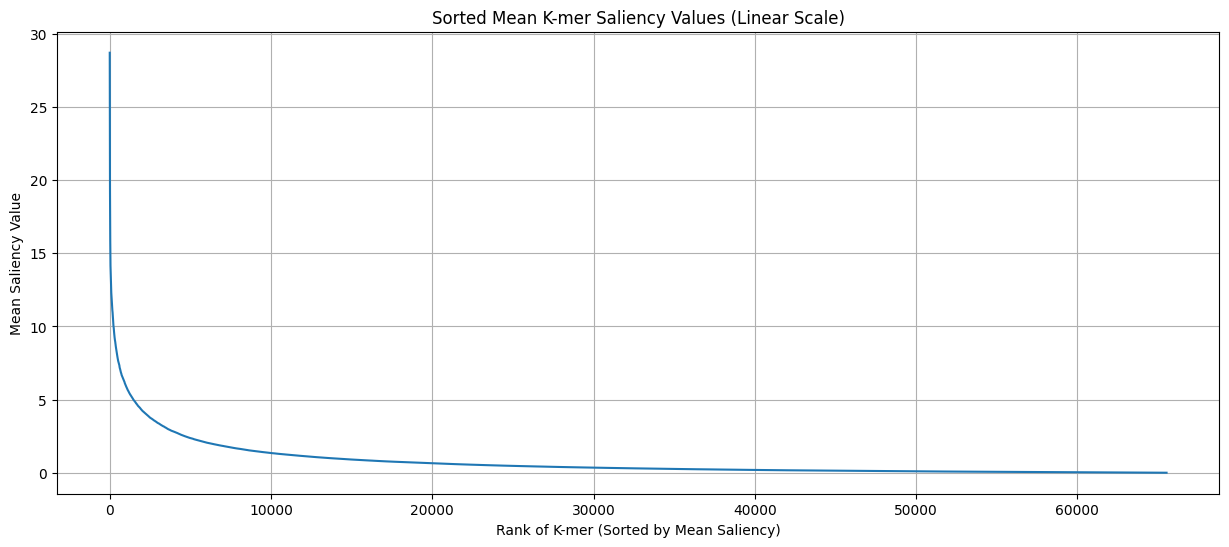

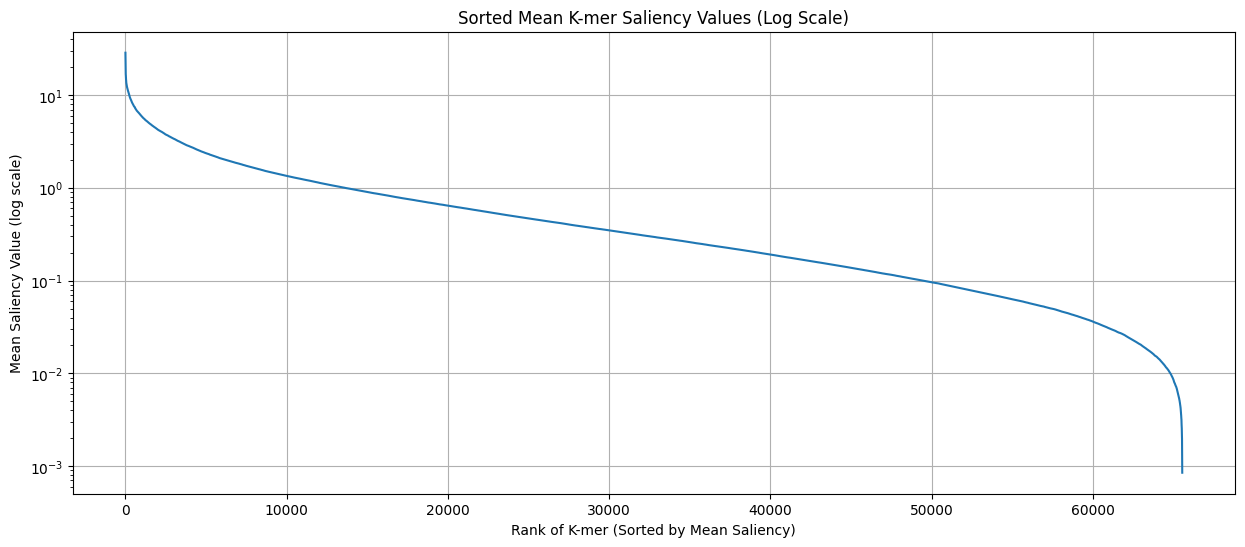

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming sorted_mean_kmer_saliency is available from the previous step

# Plot sorted mean saliency values (linear scale)
plt.figure(figsize=(15, 6))
plt.plot(sorted_mean_kmer_saliency.values)
plt.title('Sorted Mean K-mer Saliency Values (Linear Scale)')
plt.xlabel('Rank of K-mer (Sorted by Mean Saliency)')
plt.ylabel('Mean Saliency Value')
plt.grid(True)
plt.show()

# Plot sorted mean saliency values (log scale for y-axis)
plt.figure(figsize=(15, 6))
plt.plot(sorted_mean_kmer_saliency.values)
plt.yscale('log') # Set y-axis to log scale
plt.title('Sorted Mean K-mer Saliency Values (Log Scale)')
plt.xlabel('Rank of K-mer (Sorted by Mean Saliency)')
plt.ylabel('Mean Saliency Value (log scale)')
plt.grid(True)
plt.show()

In [30]:
import pandas as pd

# Define the number of top k-mers to extract per sequence
top_n_kmers = 3000

# Create an empty list to store the top k-mers for each sequence
top_kmers_per_sequence = []
sequence_names = []

# Iterate through the stored k-mer saliency values for each sequence
for i, kmer_saliency_map in enumerate(all_kmer_saliency_values):
    # Get the sequence name from the selected_sequences_df
    seq_name = selected_sequences_df.iloc[i]['File Name']
    sequence_names.append(seq_name)

    # Convert to a pandas Series for easier sorting
    kmer_saliency_series = pd.Series(kmer_saliency_map)

    # Sort the k-mers by saliency value in descending order
    sorted_kmer_saliency = kmer_saliency_series.sort_values(ascending=False)

    # Get the top N k-mers
    top_kmers = sorted_kmer_saliency.head(top_n_kmers).index.tolist()

    # Append the list of top k-mers for this sequence
    top_kmers_per_sequence.append(top_kmers)

# Create a DataFrame
# The number of columns will be top_n_kmers. We can name them kmer_1, kmer_2, ...
column_names = [f'kmer_{j+1}' for j in range(top_n_kmers)]
top_kmers_df = pd.DataFrame(top_kmers_per_sequence, index=sequence_names, columns=column_names)

# Display the first few rows of the DataFrame
print(f"DataFrame containing top {top_n_kmers} k-mers per sequence:")
display(top_kmers_df.head())

# Define the filename for saving the DataFrame
output_filename = "top_kmers_per_sequence.csv"

# Save the DataFrame to a CSV file
top_kmers_df.to_csv(output_filename)

print(f"\nTop k-mers saved to {output_filename}")

DataFrame containing top 3000 k-mers per sequence:


,kmer_1,kmer_2,kmer_3,kmer_4,kmer_5,kmer_6,kmer_7,kmer_8,kmer_9,kmer_10,...,kmer_2991,kmer_2992,kmer_2993,kmer_2994,kmer_2995,kmer_2996,kmer_2997,kmer_2998,kmer_2999,kmer_3000
SRR1198972.fna,CTTTTTGC,GTGGCTAT,AGGGCTAT,TGGCGCAT,AATAAACT,AATCCCAT,AAGCCTAT,CTAATTAT,ATCGTTAT,AAGCTAAT,...,CCTTACTT,CGTACTAT,GATCCTAT,GAATTACT,TGGTCATT,AAGTTGTC,ACGGAATT,ATCGACGT,ATCTGACT,TTTTCTGC
SRR1202988.fna,AATAAACT,CTTTTTGC,GTGGCTAT,AGGGCTAT,GGGGCTAT,AATCCCAT,AAGCCTAT,AAGATTAT,GTTTTTGC,CTAATTAT,...,ATGTGACT,CCCCGCGT,GCTAGTAT,TTGTGCAT,TTGGGACT,ACTAGATT,CTAATTTA,TTGTATAT,ATTCAATT,GTACCTAT
SRR1257274.fna,CTTTTTGC,AGGGCTAT,AATAAACT,CTAATTAT,AATCCCAT,AAGCCTAT,AGCTGTAT,AGCGTTAT,GTGGCTAT,AAAGTTAT,...,CCTTCTGC,GGATGGTC,TCGATCAT,TTGCATAC,CCAAGCAT,AGACAGTT,TTGCTGCT,AAACACCT,GACCAAAT,TTGAAACT
SRR1973886.fna,CTTTTTGC,AGGGCTAT,AAGATTAT,AAGCCTAT,AATCCCAT,AATAAACT,AAGCTAAT,TGGCGCAT,GGGGCTAT,AAAGCTAT,...,AAATTATT,GCGAACCT,TTATCCAT,TCGTGTTC,CTTTTTAT,TAGGGTTC,TGCTCACT,CTACAGCT,AGCGCGTC,ATCATAAT
SRR2407662.fna,AGGGCTAT,CTTTTTGC,AATAAACT,TGGCGCAT,GTGGCTAT,AAGCCTAT,AATCCCAT,CTAATTAT,AGTATCAT,CCCTGCAT,...,ACATAGCT,ACACCTAT,ATCTCCCG,TTTGCACT,GGTCCATT,AGTGCACT,GGCAGCTT,GGTAGTCT,AACCTGCT,TGCAAGCT



Top k-mers saved to top_kmers_per_sequence.csv


In [31]:
top_kmers_df.to_csv("top_kmers.csv")


In [32]:
%ls

 amrfinder
 CFSA15SA072_peaks.fasta
 condacolab_install.log
 Conversion_Table_4.csv
 Conversion_Table_6.csv
 Conversion_Table_7.csv
 Conversion_Table.csv
'Data Labels'/
 Datasets/
 Datasets_fcgr/
 Datasets_fcgr_6/
 Datasets_fcgr_6.zip
 Datasets_fcgr_7/
 Datasets_fcgr_7.zip
 Datasets_fcgr.zip
 Escherichia_coli/
 Escherichia_coli_all_seqs.fasta
'Escherichia coli_correlation_matrix.png'
 fcgr-0.1-py3-none-any.whl
 full_drug_summary.csv
 general_model_null_percentages_per_species.csv
 general_model_overall_null_percentages.csv
 Homology_splitting/
 Klebsiella_pneumoniae_all_seqs.fasta
 Master_consensus_RS_ordered.csv
 Master_Table.csv
 Master_Table_filled_NaN.csv
 Master_Table_For_Training.csv
 Master_Table.gsheet
 Master_Table_predicted_labels.csv
 Master_Table_Updated.csv
 Master_Table_with_abricate_labels_cards_cleaned.csv
 Master_Table_with_abricate_labels_ncbi_cleaned.csv
 Master_Table_with_abricate_labels_resfinder_cleaned.csv
 Master_Table_with_predicted.csv
 Master_weighted_consens

In [33]:
# Calculate the frequency of each k-mer across all sequences
# We can unstack the DataFrame to get a single Series of all k-mers
all_kmers_series = top_kmers_df.unstack().dropna()

# Count the occurrences of each unique k-mer
kmer_counts = all_kmers_series.value_counts()

# Calculate the frequency (percentage of sequences containing the k-mer)
# Since each row represents a sequence and has 3000 top kmers, we can count
# how many sequences each kmer appeared in the top 3000.
# However, a more meaningful frequency might be the percentage of sequences
# where a kmer appeared at least once in their top 3000.

# Let's get all unique kmers in the top 3000 across all sequences
unique_top_kmers = pd.unique(top_kmers_df.values.flatten())

# Create a boolean DataFrame indicating if a kmer is in the top 3000 for each sequence
kmer_presence_df = pd.DataFrame(index=top_kmers_df.index, columns=unique_top_kmers, dtype=bool)

for index, row in top_kmers_df.iterrows():
    present_kmers = set(row.dropna().tolist())
    for kmer in unique_top_kmers:
        kmer_presence_df.loc[index, kmer] = kmer in present_kmers

# Calculate the percentage of sequences each k-mer is present in the top 3000
kmer_presence_percentage = kmer_presence_df.sum(axis=0) / len(top_kmers_df) * 100

# Sort k-mers by their presence percentage in descending order
sorted_kmer_presence = kmer_presence_percentage.sort_values(ascending=False)

print("Percentage of sequences each top k-mer is present in:")
display(sorted_kmer_presence.head())

# We can also look at the overall count of how many times each kmer appeared in the top 3000 lists
print("\nTotal count of each k-mer in the top 3000 lists across all sequences:")
display(kmer_counts.head())

Percentage of sequences each top k-mer is present in:


,0
CTAGTCAT,100.0
CTTTTTGC,100.0
GTGGCTAT,100.0
CATGCTAT,100.0
CTCCCCAT,100.0



Total count of each k-mer in the top 3000 lists across all sequences:


,count
GAAGCTGC,16
ATAATTAT,16
AAAACCGT,16
AATCATAT,16
GCTGCAAT,16


In [34]:
import pandas as pd

# Load the top k-mers data from the CSV file
top_kmers_df = pd.read_csv("top_kmers_per_sequence.csv", index_col=0)

# Display the first few rows of the loaded DataFrame to confirm
print("Loaded top k-mers DataFrame:")
display(top_kmers_df.head())

Loaded top k-mers DataFrame:


,kmer_1,kmer_2,kmer_3,kmer_4,kmer_5,kmer_6,kmer_7,kmer_8,kmer_9,kmer_10,...,kmer_2991,kmer_2992,kmer_2993,kmer_2994,kmer_2995,kmer_2996,kmer_2997,kmer_2998,kmer_2999,kmer_3000
SRR1198972.fna,CTTTTTGC,GTGGCTAT,AGGGCTAT,TGGCGCAT,AATAAACT,AATCCCAT,AAGCCTAT,CTAATTAT,ATCGTTAT,AAGCTAAT,...,CCTTACTT,CGTACTAT,GATCCTAT,GAATTACT,TGGTCATT,AAGTTGTC,ACGGAATT,ATCGACGT,ATCTGACT,TTTTCTGC
SRR1202988.fna,AATAAACT,CTTTTTGC,GTGGCTAT,AGGGCTAT,GGGGCTAT,AATCCCAT,AAGCCTAT,AAGATTAT,GTTTTTGC,CTAATTAT,...,ATGTGACT,CCCCGCGT,GCTAGTAT,TTGTGCAT,TTGGGACT,ACTAGATT,CTAATTTA,TTGTATAT,ATTCAATT,GTACCTAT
SRR1257274.fna,CTTTTTGC,AGGGCTAT,AATAAACT,CTAATTAT,AATCCCAT,AAGCCTAT,AGCTGTAT,AGCGTTAT,GTGGCTAT,AAAGTTAT,...,CCTTCTGC,GGATGGTC,TCGATCAT,TTGCATAC,CCAAGCAT,AGACAGTT,TTGCTGCT,AAACACCT,GACCAAAT,TTGAAACT
SRR1973886.fna,CTTTTTGC,AGGGCTAT,AAGATTAT,AAGCCTAT,AATCCCAT,AATAAACT,AAGCTAAT,TGGCGCAT,GGGGCTAT,AAAGCTAT,...,AAATTATT,GCGAACCT,TTATCCAT,TCGTGTTC,CTTTTTAT,TAGGGTTC,TGCTCACT,CTACAGCT,AGCGCGTC,ATCATAAT
SRR2407662.fna,AGGGCTAT,CTTTTTGC,AATAAACT,TGGCGCAT,GTGGCTAT,AAGCCTAT,AATCCCAT,CTAATTAT,AGTATCAT,CCCTGCAT,...,ACATAGCT,ACACCTAT,ATCTCCCG,TTTGCACT,GGTCCATT,AGTGCACT,GGCAGCTT,GGTAGTCT,AACCTGCT,TGCAAGCT


In [35]:
# Assuming sorted_kmer_presence is available from the previous cell

# Define a threshold for considering a k-mer "common" (e.g., present in > 50% of sequences)
# This threshold can be adjusted based on the user's definition of "common"
commonality_threshold = 50

# Filter k-mers that appear in a percentage of sequences above the threshold
common_kmers = sorted_kmer_presence[sorted_kmer_presence >= commonality_threshold]

print(f"K-mers present in at least {commonality_threshold}% of the selected sequences (sorted by presence percentage):")
display(common_kmers)

# You can also get a list of just the common k-mer sequences
list_of_common_kmers = common_kmers.index.tolist()

print("\nList of common k-mers:")
print(list_of_common_kmers)

K-mers present in at least 50% of the selected sequences (sorted by presence percentage):


,0
CTAGTCAT,100.0
CTTTTTGC,100.0
GTGGCTAT,100.0
CATGCTAT,100.0
CTCCCCAT,100.0
...,...
TAGACTAT,50.0
GCCGGTAT,50.0
TAGGAGTC,50.0
ATAGCTGC,50.0



List of common k-mers:
['CTAGTCAT', 'CTTTTTGC', 'GTGGCTAT', 'CATGCTAT', 'CTCCCCAT', 'AGCCTAAT', 'GGTATTGC', 'CTGCAACT', 'GACTTTAT', 'GCTTGTAT', 'ATCATTGC', 'TTTGCTGC', 'AAGATTAT', 'GATGTTAT', 'GCCGTTAT', 'AATCATAT', 'AGCTGTAT', 'CCCTGCAT', 'AGTATCAT', 'GGGGCTAT', 'CTCGTTAT', 'AAGCTAAT', 'ATCGTTAT', 'CTAATTAT', 'AAGCCTAT', 'AATCCCAT', 'AATAAACT', 'TGGCGCAT', 'AGGGCTAT', 'AGCGTTAT', 'AATAAATT', 'AAGGTTAT', 'CTCAAATT', 'CGGGTTAT', 'TAACAATT', 'AGTATTAT', 'CTGCAATT', 'TTTTGGCT', 'ATGTGCAT', 'ACGTCTAT', 'CCACCTAT', 'CTCCCATT', 'CTTTTGCT', 'CAGATCAT', 'AGGTCTAT', 'CTTTATAT', 'GAGCAACT', 'GTCTCTAT', 'GTACATAT', 'TGTTGCAT', 'CTTCATAT', 'TAAGTTAT', 'AATGGGTC', 'GCAATTAT', 'AAAGAGCT', 'TTAAAACT', 'AAAACCGT', 'CACCCCGT', 'GGATGTAT', 'GCCCTTGC', 'AGATAACT', 'AATTCTAT', 'CCTTATAT', 'GTCTAAAT', 'GAGGCAAT', 'GGATAACT', 'CTTTATGC', 'TTTTTCAT', 'AACACCGT', 'CGTTGTAT', 'GCTTGCAT', 'AGATAATT', 'TTATCTAT', 'CTGGGGCT', 'GTTACTAT', 'AAGTTTGC', 'ACAGTCAT', 'GAAAAACT', 'GCCGCTAT', 'AGAAAACT', 'TGAGCTAT', 'AT

In [36]:
# Assuming sorted_mean_kmer_saliency and common_kmers (list of common k-mers)
# are available from previous steps.

# Create a Series of mean saliency values specifically for the common k-mers
common_kmer_mean_saliency = sorted_mean_kmer_saliency[common_kmers.index]

print("Mean saliency values for common k-mers (sorted by commonality percentage):")
display(common_kmer_mean_saliency.head())

# You can also sort this by mean saliency to see the most salient common kmers
sorted_common_kmer_mean_saliency = common_kmer_mean_saliency.sort_values(ascending=False)

print("\nMean saliency values for common k-mers (sorted by mean saliency):")
display(sorted_common_kmer_mean_saliency.head())

Mean saliency values for common k-mers (sorted by commonality percentage):


,0
CTAGTCAT,16.659867
CTTTTTGC,28.710331
GTGGCTAT,25.297091
CATGCTAT,16.158689
CTCCCCAT,17.431843



Mean saliency values for common k-mers (sorted by mean saliency):


,0
CTTTTTGC,28.710331
AGGGCTAT,27.590534
AATAAACT,27.103166
AAGCCTAT,26.824991
TGGCGCAT,26.261403


102 / 2814 important k-mers in blaCMY-2 (3.6%).
Saliency-weighted fraction: 4.96% of total model saliency mass is inside blaCMY-2.


/tmp/ipython-input-2065677533.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(topN.index, rotation=90, fontsize=8)


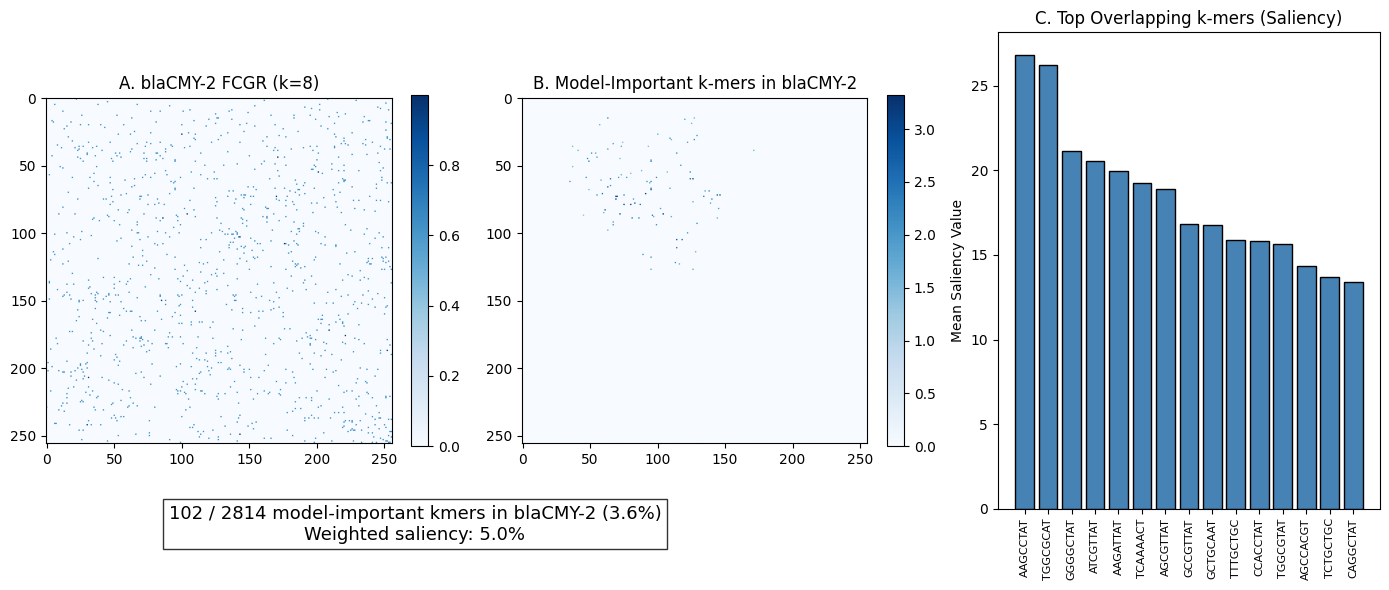

In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Use your helper functions ---
def reverse_map_saliency(sequence, k=8, kmer_saliency_dict=None, default_value=0.0):
    saliency_track = np.zeros(len(sequence) - k + 1)
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k].upper()
        saliency_track[i] = kmer_saliency_dict.get(kmer, default_value)
    return saliency_track

def normalize_min_max(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-9)

# --- Load blaCMY-2 ---
bla_path = "/content/blaCMY-2_salmonella.fasta"
bla_seq = load_all_sequences(bla_path)

# --- Generate FCGR ---
fcgr_matrix, positions, keys = chaos_frequency_matrix(
    fasta_string=bla_seq,
    kmer_length=8,
    chaos_game_kmer_array=None,
    pseudo_count=False
)
bla_fcgr = normalize_min_max(np.log1p(fcgr_matrix))

# --- Compare against ALL saliency kmers ---
all_saliency = sorted_common_kmer_mean_saliency
top_kmers = all_saliency.index.tolist()

bla_kmers_present = [k for k in top_kmers if k in bla_seq]

# Saliency values for overlapping kmers
overlap_saliency = all_saliency.loc[
    all_saliency.index.isin(bla_kmers_present)
].sort_values(ascending=False)

# Raw overlap count
overlap_count = len(overlap_saliency)
total_count = len(all_saliency)
overlap_fraction = 100 * overlap_count / total_count

# Saliency-weighted overlap
total_saliency = all_saliency.sum()
overlap_saliency_sum = overlap_saliency.sum()
saliency_weighted_fraction = 100 * overlap_saliency_sum / total_saliency

print(f"{overlap_count} / {total_count} important k-mers in blaCMY-2 ({overlap_fraction:.1f}%).")
print(f"Saliency-weighted fraction: {saliency_weighted_fraction:.2f}% of total model saliency mass is inside blaCMY-2.")

# --- Build highlight matrix ---
highlight_matrix = np.zeros_like(bla_fcgr)
for (i,j), k in np.ndenumerate(keys):
    k = str(k)
    if k in overlap_saliency.index:
        highlight_matrix[i,j] = overlap_saliency[k]

highlight_matrix =np.log1p( highlight_matrix)
# --- Plot tri-panel figure ---
fig = plt.figure(figsize=(14,6))

# Panel A: blaCMY-2 FCGR
ax1 = plt.subplot(1,3,1)
im1 = ax1.imshow(bla_fcgr, cmap="Blues")
ax1.set_title("A. blaCMY-2 FCGR (k=8)")
plt.colorbar(im1, ax=ax1, fraction=0.046)

# Panel B: FCGR overlap with saliency
ax2 = plt.subplot(1,3,2)
im2 = ax2.imshow(highlight_matrix, cmap="Blues")
ax2.set_title("B. Model-Important k-mers in blaCMY-2")
plt.colorbar(im2, ax=ax2, fraction=0.046)

# Panel C: Bar chart with inline annotation
ax3 = plt.subplot(1,3,3)
topN = overlap_saliency.head(15)
bars = ax3.bar(topN.index, topN.values, color="steelblue", edgecolor="black")

ax3.set_title("C. Top Overlapping k-mers (Saliency)")
ax3.set_ylabel("Mean Saliency Value")
ax3.set_xticklabels(topN.index, rotation=90, fontsize=8)
# Place overlap stats as a figure-level text box below A+B
summary_text = (
    f"{overlap_count} / {total_count} model-important kmers in blaCMY-2 "
    f"({overlap_fraction:.1f}%)\n"
    f"Weighted saliency: {saliency_weighted_fraction:.1f}%"
)

fig.text(
    0.30, 0.15, summary_text,   # position: center under panels A+B
    ha='center', va='top',
    fontsize=13, color="black", weight="regular",
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

plt.tight_layout()
plt.show()

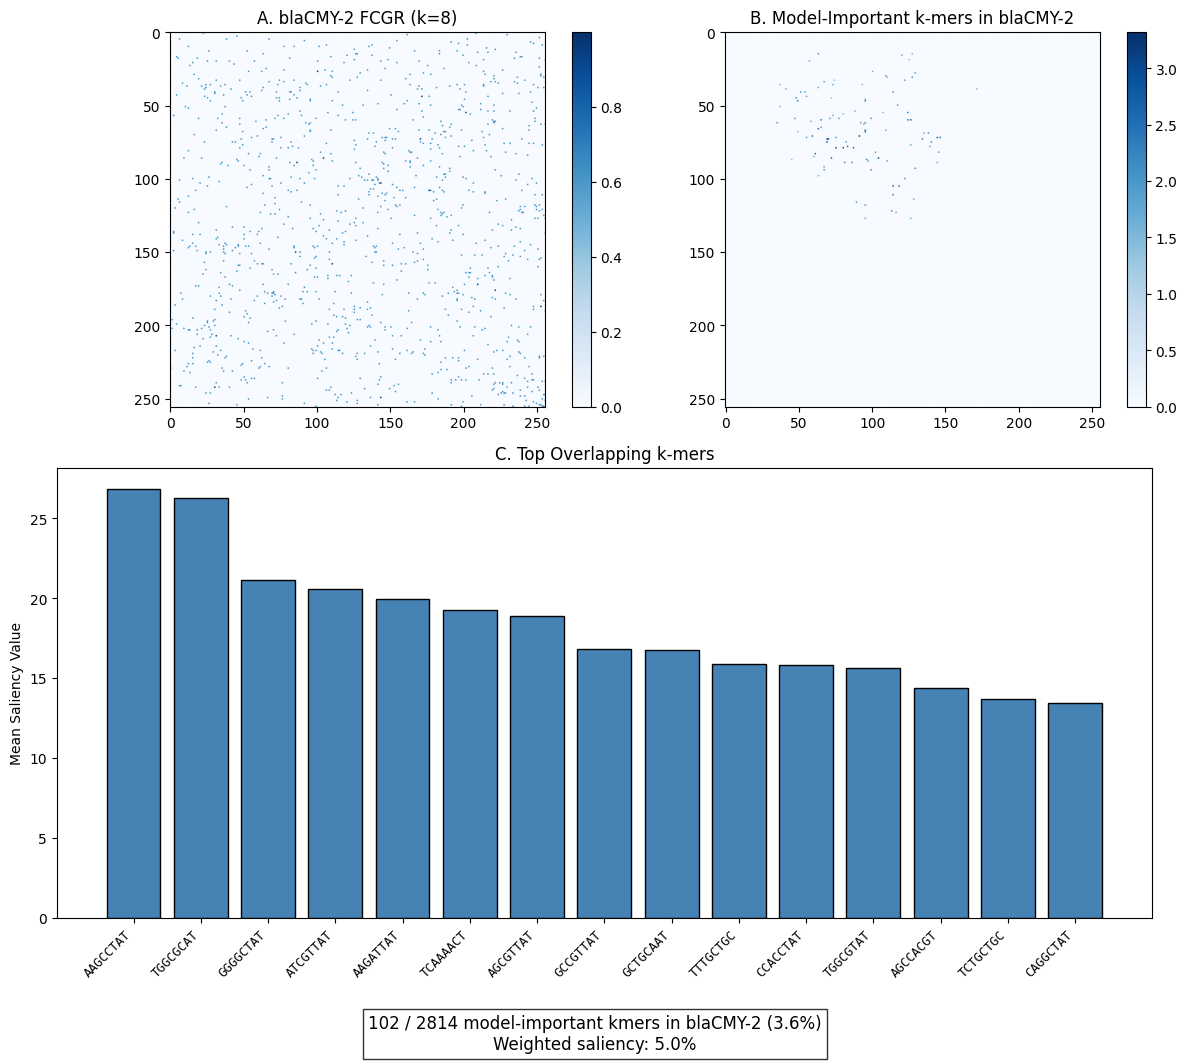

In [76]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 10))  # slightly taller now
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2], width_ratios=[1, 1])

# Panel A: FCGR
ax1 = fig.add_subplot(gs[0,0])
im1 = ax1.imshow(bla_fcgr, cmap="Blues")
ax1.set_title("A. blaCMY-2 FCGR (k=8)")
plt.colorbar(im1, ax=ax1, fraction=0.046)

# Panel B: Model-important
ax2 = fig.add_subplot(gs[0,1])
im2 = ax2.imshow(highlight_matrix, cmap="Blues")
ax2.set_title("B. Model-Important k-mers in blaCMY-2")
plt.colorbar(im2, ax=ax2, fraction=0.046)

# Panel C: Bar chart spanning bottom row
ax3 = fig.add_subplot(gs[1,:])  # spans both columns
topN = overlap_saliency.head(15)
bars = ax3.bar(topN.index, topN.values, color="steelblue", edgecolor="black")

ax3.set_title("C. Top Overlapping k-mers")
ax3.set_ylabel("Mean Saliency Value")
ax3.set_xticks(range(len(topN)))
ax3.set_xticklabels(topN.index, rotation=45, ha='right', fontsize=9, fontfamily='monospace')

# Add summary text box under the bar plot
summary_text = (
    f"{overlap_count} / {total_count} model-important kmers in blaCMY-2 "
    f"({overlap_fraction:.1f}%)\n"
    f"Weighted saliency: {saliency_weighted_fraction:.1f}%"
)

fig.text(
    0.5, -0.02, summary_text,
    ha='center', va='top',
    fontsize=12, color="black", weight="regular",
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

plt.tight_layout()
plt.show()

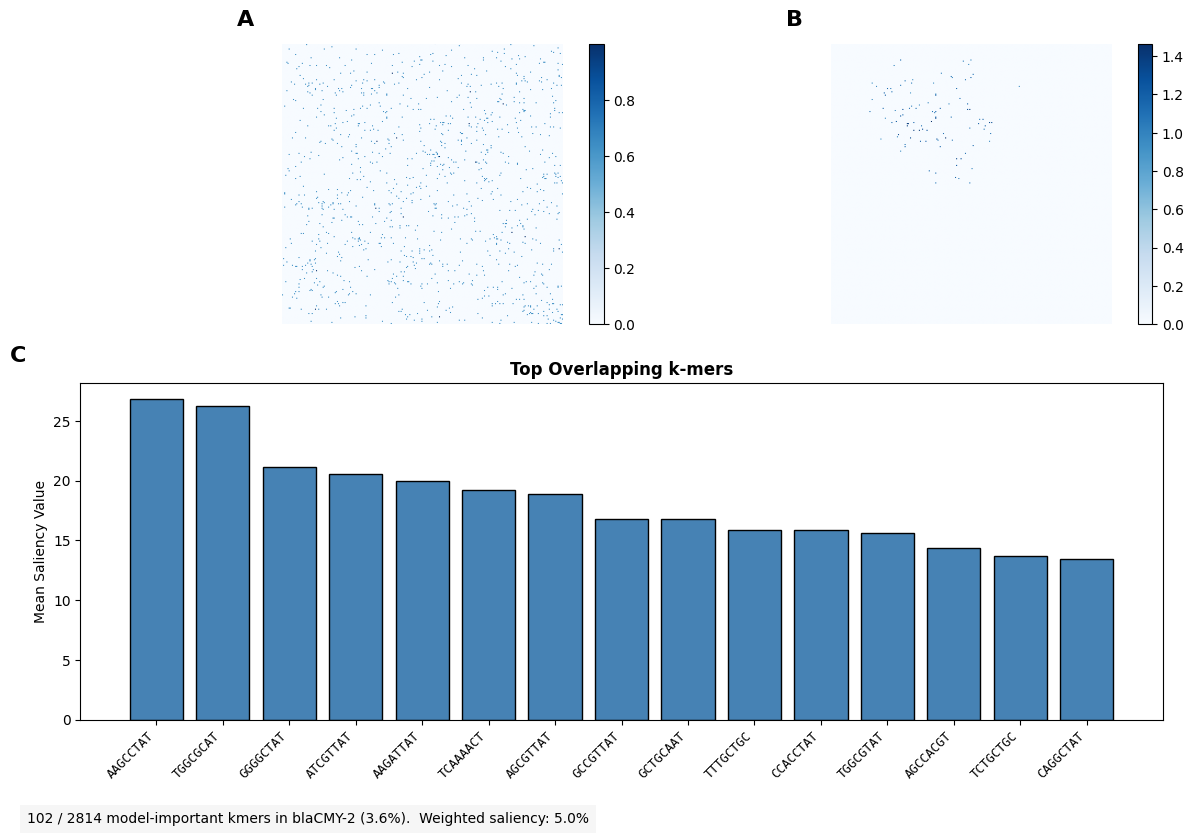

In [77]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2], width_ratios=[1, 1])

# --- Panel A ---
ax1 = fig.add_subplot(gs[0,0])
im1 = ax1.imshow(bla_fcgr, cmap="Blues")
ax1.axis("off")  # cleaner look, no ticks
plt.colorbar(im1, ax=ax1, fraction=0.046)
ax1.text(-0.1, 1.05, "A", transform=ax1.transAxes, fontsize=16,
         fontweight="bold", va="bottom", ha="right")

# --- Panel B ---
ax2 = fig.add_subplot(gs[0,1])
im2 = ax2.imshow(np.log1p(highlight_matrix), cmap="Blues")  # log scale
ax2.axis("off")
plt.colorbar(im2, ax=ax2, fraction=0.046)
ax2.text(-0.1, 1.05, "B", transform=ax2.transAxes, fontsize=16,
         fontweight="bold", va="bottom", ha="right")

# --- Panel C ---
ax3 = fig.add_subplot(gs[1,:])
topN = overlap_saliency.head(15)
bars = ax3.bar(topN.index, topN.values, color="steelblue", edgecolor="black")

ax3.set_ylabel("Mean Saliency Value")
ax3.set_xticks(range(len(topN)))
ax3.set_xticklabels(topN.index, rotation=45, ha='right', fontsize=9, fontfamily='monospace')
ax3.text(-0.05, 1.05, "C", transform=ax3.transAxes, fontsize=16,
         fontweight="bold", va="bottom", ha="right")

ax3.set_title("Top Overlapping k-mers", fontsize=12, weight="semibold")

# --- Summary text ---
fig.text(
    0.02, -0.02,
    f"{overlap_count} / {total_count} model-important kmers in blaCMY-2 "
    f"({overlap_fraction:.1f}%).  "
    f"Weighted saliency: {saliency_weighted_fraction:.1f}%",
    ha='left', va='top', fontsize=10, color="black",
    bbox=dict(facecolor='whitesmoke', alpha=0.9, edgecolor='none', pad=5)
)

plt.tight_layout()
plt.show()

In [78]:
# Panel A
plt.figure(figsize=(5,5))
plt.imshow(bla_fcgr, cmap="Blues")
plt.title("blaCMY-2 FCGR (k=8)")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.savefig("panelA_fcgr.png", dpi=300)
plt.close()

# Panel B
plt.figure(figsize=(5,5))
plt.imshow(highlight_matrix, cmap="Blues")
plt.title("Model-Important k-mers in blaCMY-2")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.savefig("panelB_overlap.png", dpi=300)
plt.close()

# Panel C
plt.figure(figsize=(6,4))
topN = overlap_saliency.head(15)
plt.bar(topN.index, topN.values, color="steelblue")
plt.ylabel("Mean Saliency Value")
plt.title("Top Overlapping k-mers (Saliency)")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.tight_layout()
plt.savefig("panelC_barchart.png", dpi=300)
plt.close()